<a href="https://colab.research.google.com/github/Hemasankar007/SmartCity/blob/main/Smartcity_traffic_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the google colab/python docker image:
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output


# Any results you write to the current directory are saved as output.

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
df_train = pd.read_csv('/content/train_aWnotuB.csv',parse_dates=[0],infer_datetime_format=True)
df_test = pd.read_csv('/content/test_BdBKkAj.csv',parse_dates=[0],infer_datetime_format=True)

In [ ]:
print("Size of training set: "+ str(df_train.shape))
print("Size of test set: "+ str(df_test.shape))
print('\n')
print('columns in train: '+str(df_train.columns.tolist()))
print('columns in test: '+str(df_test.columns.tolist()))

df_train.head()

Size of training set: (48120, 4)
Size of test set: (11808, 3)


columns in train: ['DateTime', 'Junction', 'Vehicles', 'ID']
columns in test: ['DateTime', 'Junction', 'ID']


,DateTime,Junction,Vehicles,ID
0,2015-01-11 00:00:00,1,15,20151101001
1,2015-01-11 01:00:00,1,13,20151101011
2,2015-01-11 02:00:00,1,10,20151101021
3,2015-01-11 03:00:00,1,7,20151101031
4,2015-01-11 04:00:00,1,9,20151101041


In [ ]:
df_tmp = df_train.set_index(['Junction','DateTime'])

In [ ]:
level_values = df_tmp.index.get_level_values

In [ ]:
time_targets = df_tmp.groupby([level_values(0)] + [pd.Grouper(freq='1M', level=-1)])['Vehicles'].sum()
time_targets

Junction  DateTime  
1         2015-01-31     866
          2015-02-28    1186
          2015-03-31    1100
          2015-04-30    1035
          2015-05-31     852
                        ... 
4         2017-08-31     983
          2017-09-30    1063
          2017-10-31    1058
          2017-11-30     986
          2017-12-31     936
Name: Vehicles, Length: 120, dtype: int64

In [ ]:
del df_tmp
del time_targets

In [ ]:
train = df_train.pivot(index='DateTime', columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-01-11 00:00:00,15.0,6.0,9.0,NaN
2015-01-11 01:00:00,13.0,6.0,7.0,NaN
2015-01-11 02:00:00,10.0,5.0,5.0,NaN
2015-01-11 03:00:00,7.0,6.0,1.0,NaN
2015-01-11 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-12-06 19:00:00,120.0,42.0,21.0,10.0
2017-12-06 20:00:00,107.0,37.0,18.0,7.0
2017-12-06 21:00:00,105.0,40.0,21.0,8.0


In [ ]:
train.isnull().sum()

Junction
1        0
2        0
3        0
4    10248
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14592 entries, 2015-01-11 00:00:00 to 2017-12-06 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       14592 non-null  float64
 1   2       14592 non-null  float64
 2   3       14592 non-null  float64
 3   4       4344 non-null   float64
dtypes: float64(4)
memory usage: 570.0 KB


In [ ]:
value=round(train[4].max())/1.0
value

36.0

In [ ]:
train = train.fillna(value)

In [ ]:
def gen_lag_features(df, n_in=1,n_out=1,dropnan=True):
    n_vars = df.shape[1]
    cols, names = list(), list()
    #input sequence (t-n,.....t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[('Junction %d (H-%d)' %(j+1, i)) for j in range(n_vars)]
    # forecast sequence (t,t+1,.....t+n)
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names+=[('Junction %d (H)' %(j+1)) for j in range(n_vars)]
        else:
            names+=[('Junction %d (H+%d)' %(j+1,i)) for j in range(n_vars)]
    #put it all together
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
Xy_train= gen_lag_features(train)
Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-01-11 01:00:00,15.0,6.0,9.0,36.0,13.0,6.0,7.0,36.0
2015-01-11 02:00:00,13.0,6.0,7.0,36.0,10.0,5.0,5.0,36.0
2015-01-11 03:00:00,10.0,5.0,5.0,36.0,7.0,6.0,1.0,36.0
2015-01-11 04:00:00,7.0,6.0,1.0,36.0,9.0,7.0,2.0,36.0
2015-01-11 05:00:00,9.0,7.0,2.0,36.0,6.0,2.0,2.0,36.0
...,...,...,...,...,...,...,...,...
2017-12-06 19:00:00,114.0,40.0,18.0,9.0,120.0,42.0,21.0,10.0
2017-12-06 20:00:00,120.0,42.0,21.0,10.0,107.0,37.0,18.0,7.0
2017-12-06 21:00:00,107.0,37.0,18.0,7.0,105.0,40.0,21.0,8.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))
Xy_train[Xy_train.columns]= scaler.fit_transform(Xy_train[Xy_train.columns])

Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-01-11 01:00:00,0.066225,0.106383,0.044693,1.000000,0.052980,0.106383,0.033520,1.000000
2015-01-11 02:00:00,0.052980,0.106383,0.033520,1.000000,0.033113,0.085106,0.022346,1.000000
2015-01-11 03:00:00,0.033113,0.085106,0.022346,1.000000,0.013245,0.106383,0.000000,1.000000
2015-01-11 04:00:00,0.013245,0.106383,0.000000,1.000000,0.026490,0.127660,0.005587,1.000000
2015-01-11 05:00:00,0.026490,0.127660,0.005587,1.000000,0.006623,0.021277,0.005587,1.000000
...,...,...,...,...,...,...,...,...
2017-12-06 19:00:00,0.721854,0.829787,0.094972,0.228571,0.761589,0.872340,0.111732,0.257143
2017-12-06 20:00:00,0.761589,0.872340,0.111732,0.257143,0.675497,0.765957,0.094972,0.171429
2017-12-06 21:00:00,0.675497,0.765957,0.094972,0.171429,0.662252,0.829787,0.111732,0.200000


In [ ]:
X_train = Xy_train[Xy_train.index < '2017-04-01'].iloc[:,0:4]
X_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2015-01-11 01:00:00,0.066225,0.106383,0.044693,1.000000
2015-01-11 02:00:00,0.052980,0.106383,0.033520,1.000000
2015-01-11 03:00:00,0.033113,0.085106,0.022346,1.000000
2015-01-11 04:00:00,0.013245,0.106383,0.000000,1.000000
2015-01-11 05:00:00,0.026490,0.127660,0.005587,1.000000
...,...,...,...,...
2017-03-31 19:00:00,0.476821,0.574468,0.178771,0.142857
2017-03-31 20:00:00,0.496689,0.531915,0.156425,0.200000
2017-03-31 21:00:00,0.483444,0.638298,0.156425,0.200000


In [ ]:
y_train= Xy_train[Xy_train.index < '2017-04-01'].iloc[:,4:]
y_train

,Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,
2015-01-11 01:00:00,0.052980,0.106383,0.033520,1.000000
2015-01-11 02:00:00,0.033113,0.085106,0.022346,1.000000
2015-01-11 03:00:00,0.013245,0.106383,0.000000,1.000000
2015-01-11 04:00:00,0.026490,0.127660,0.005587,1.000000
2015-01-11 05:00:00,0.006623,0.021277,0.005587,1.000000
...,...,...,...,...
2017-03-31 19:00:00,0.496689,0.531915,0.156425,0.200000
2017-03-31 20:00:00,0.483444,0.638298,0.156425,0.200000
2017-03-31 21:00:00,0.403974,0.574468,0.150838,0.228571


In [ ]:
print(X_train.shape, y_train.shape)

(11975, 4) (11975, 4)


In [ ]:
X_train = np.expand_dims(X_train.values,axis=2)
print(X_train.shape)

y_train= y_train.values
print(y_train.shape)

(11975, 4, 1)
(11975, 4)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.initializers import he_normal
import keras.backend as K

def root_mean_squared_error(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [ ]:
# Initialising the RNN
regressor= Sequential()

#Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50,activation='relu',kernel_initializer= he_normal(seed=0),input_shape=(None,1)))

#output for 4 junctions
regressor.add(Dense(units=4))

#Compiling the RNN
regressor.compile(optimizer='adam',loss= root_mean_squared_error)

In [ ]:
# Fitting the RNN to the Training set
regressor.fit(X_train,y_train,batch_size=120,epochs=100,verbose=1)

Epoch 1/100
100/100 [==============================] - 3s 5ms/step - loss: 0.2506
Epoch 2/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0426
Epoch 3/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0363
Epoch 4/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 5/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0336
Epoch 6/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0331
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0329
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0326
Epoch 9/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0324
Epoch 10/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0324
Epoch 11/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0323
Epoch 12/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0323
Epoch 13/100


In [ ]:
X_valid = Xy_train[Xy_train.index >='2017-04-01'].iloc[:,0:4]
X_valid

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2017-04-01 00:00:00,0.417219,0.553191,0.162011,0.142857
2017-04-01 01:00:00,0.403974,0.255319,0.089385,0.285714
2017-04-01 02:00:00,0.304636,0.212766,0.061453,0.142857
2017-04-01 03:00:00,0.271523,0.212766,0.050279,0.200000
2017-04-01 04:00:00,0.238411,0.276596,0.050279,0.028571
...,...,...,...,...
2017-12-06 19:00:00,0.721854,0.829787,0.094972,0.228571
2017-12-06 20:00:00,0.761589,0.872340,0.111732,0.257143
2017-12-06 21:00:00,0.675497,0.765957,0.094972,0.171429


In [ ]:
X_valid=np.expand_dims(X_valid.values,axis=2)
y_pred= regressor.predict(X_valid)

82/82 [==============================] - 0s 2ms/step


In [ ]:
# we rescale y in the integer count range
# to do that we must first reconcatenate with the X data as scaler expects a shape of 8

y_pred = scaler.inverse_transform(np.concatenate((X_valid.squeeze(), y_pred),axis=1))[:,4:]
y_pred

array([[68.20263624, 25.41322595, 26.19818799,  7.1434374 ],
       [66.45485872, 14.73754466, 17.09100141,  9.57000016],
       [53.49109915, 12.55706492, 12.78961007,  6.68232402],
       ...,
       [97.30961084, 34.74751532, 19.70596601,  8.84144387],
       [96.26106673, 36.85057366, 21.15430084,  8.8493984 ],
       [83.73665237, 35.52883089, 13.46367611,  8.78630659]])

In [ ]:
y_truth= train[train.index >= '2017-04-01']
y_truth

Junction,1,2,3,4
DateTime,,,,
2017-04-01 00:00:00,66.0,13.0,17.0,11.0
2017-04-01 01:00:00,51.0,11.0,12.0,6.0
2017-04-01 02:00:00,46.0,11.0,10.0,8.0
2017-04-01 03:00:00,41.0,14.0,10.0,2.0
2017-04-01 04:00:00,40.0,12.0,12.0,2.0
...,...,...,...,...
2017-12-06 19:00:00,120.0,42.0,21.0,10.0
2017-12-06 20:00:00,107.0,37.0,18.0,7.0
2017-12-06 21:00:00,105.0,40.0,21.0,8.0


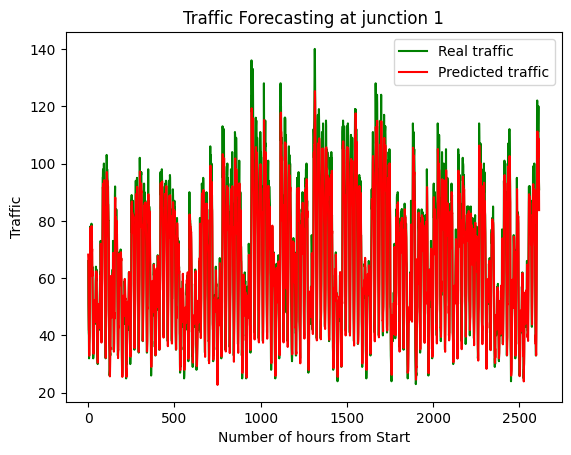

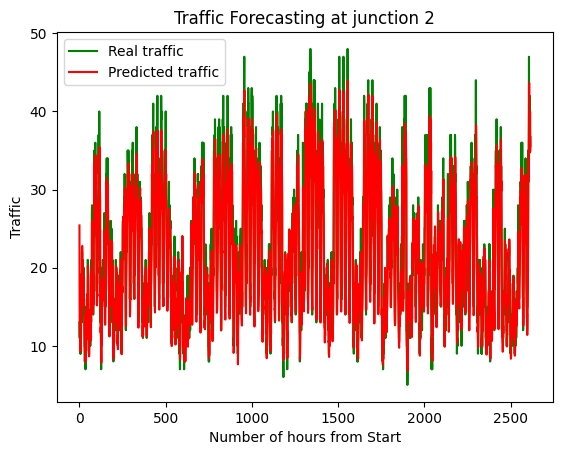

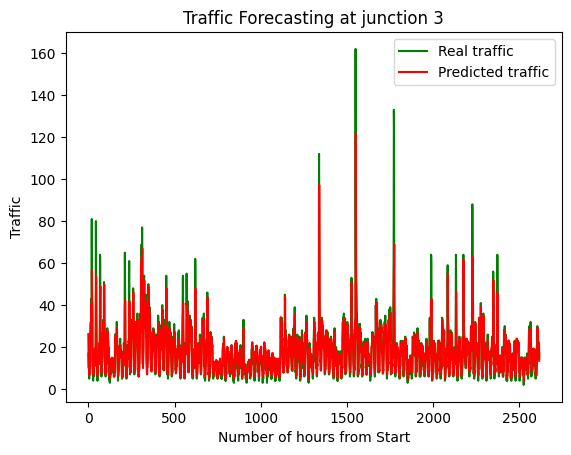

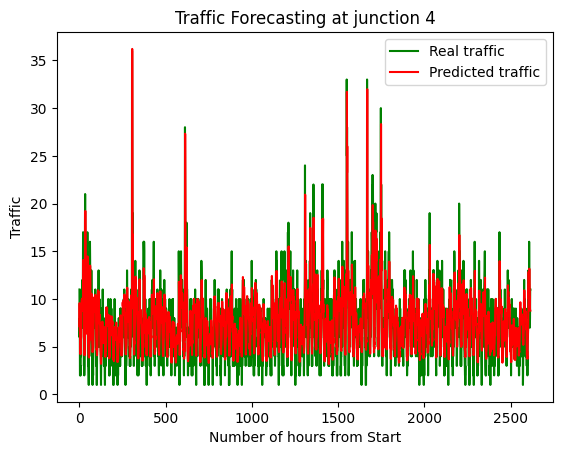

In [ ]:
# Visualising Result for the junctions
for junction in range(4):
    plt.figure
    plt.plot(y_truth.values[:,junction],color='green', label='Real traffic')
    plt.plot(y_pred[:,junction],color='red',label ='Predicted traffic')
    plt.title('Traffic Forecasting at junction %i' % (junction+1))
    plt.xlabel('Number of hours from Start')
    plt.ylabel('Traffic')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true,y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
rmse(y_truth,y_pred)

5.8755234635927875

In [ ]:
import pandas as pd
import numpy as np
trdf = pd.read_csv('/content/train_aWnotuB.csv')
trainMat= trdf.to_numpy()
tedf = pd.read_csv('/content/test_BdBKkAj.csv')
testMat=tedf.to_numpy()
train=[]
target=[]
print(trainMat)
for i in trainMat:
    s=i[3]
    year=s/(10**7)
    s=s%(10**7)
    month=s/(10**5)
    s=s%(10**5)
    date=s/(10**3)
    s=s%(10**3)
    time=s/(10)
    s=s%(10)
    junction =s
    train.append([year,month,date,time,junction])
    target.append(i[2])
X= np.array(train)
y=np.array(target)

[['01-11-2015 00:00' 1 15 20151101001]
 ['01-11-2015 01:00' 1 13 20151101011]
 ['01-11-2015 02:00' 1 10 20151101021]
 ...
 ['30-06-2017 21:00' 4 16 20170630214]
 ['30-06-2017 22:00' 4 22 20170630224]
 ['30-06-2017 23:00' 4 12 20170630234]]


In [ ]:
jun1=[]
jun2=[]
jun3=[]
jun4=[]
jun5=[]
jun=[jun1,jun2,jun3,jun4,jun5]
for i in range(0,len(train),24):
    ct=0
    for j in range(24):
        ct+=target[i+j]
    jun[train[i][4]-1].append(ct)
jun[3]=[0]*(len(jun[0])-len(jun[3]))+jun[3]
print(len(jun[0]),len(jun[1]),len(jun[2]),len(jun[3]))

k=7
week=[[] for i in range(k)]
for i in range(len(jun[1])):
    week[i%k].append(jun[1][i])
for i in range(k):
    print(np.mean(week[i]))
hour=[[] for i in range(24)]
for i in range(len(jun[0])*24+len(jun[1])*24, len(jun[0])*24+len(jun[1])*24+len(jun[2])*24):
    hour[i%24].append(target[i])
for i in range(24):
    print(np.mean(hour[i]))

temp=[-i for i in jun[3]]
jun[4]=np.add(jun[2],temp)

608 608 608 608
243.45977011494253
365.4942528735632
397.367816091954
394.0
384.632183908046
358.62068965517244
249.90697674418604
14.174342105263158
9.856907894736842
8.055921052631579
6.776315789473684
5.978618421052632
5.685855263157895
6.2368421052631575
7.550986842105263
9.057565789473685
11.429276315789474
15.004934210526315
17.1875
17.707236842105264
16.049342105263158
17.57236842105263
17.37171052631579
16.88157894736842
16.901315789473685
17.929276315789473
19.129934210526315
20.200657894736842
18.72203947368421
17.394736842105264
15.800986842105264


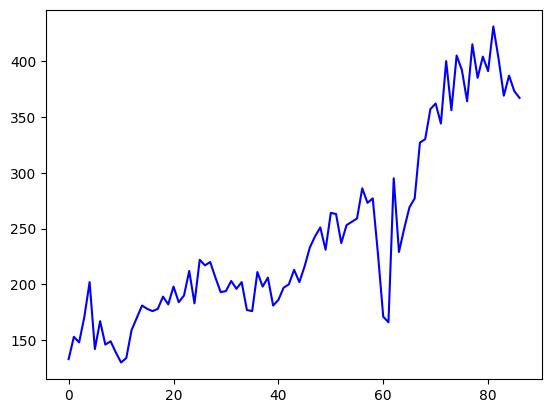

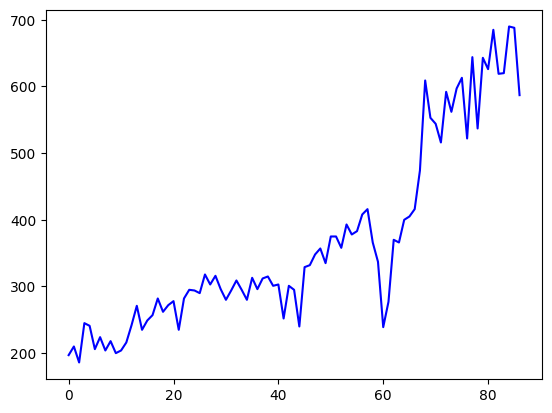

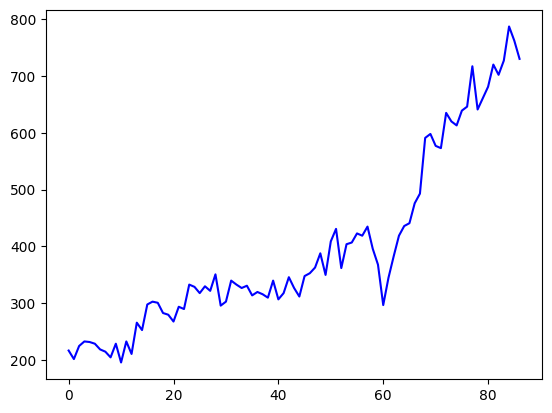

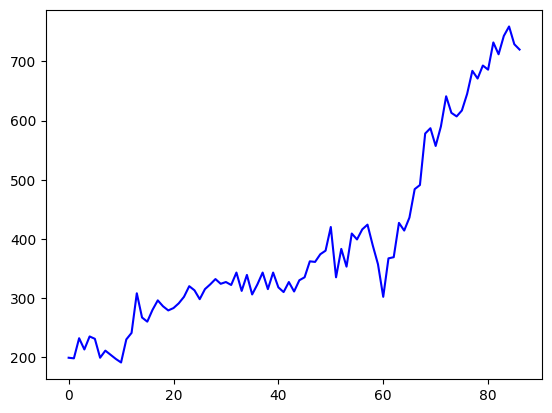

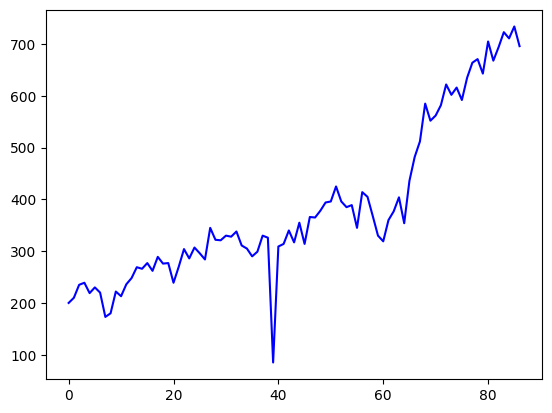

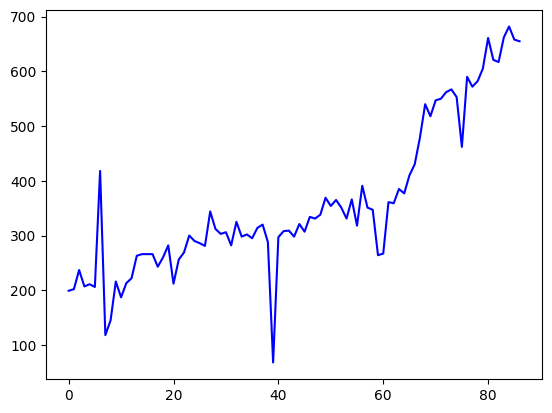

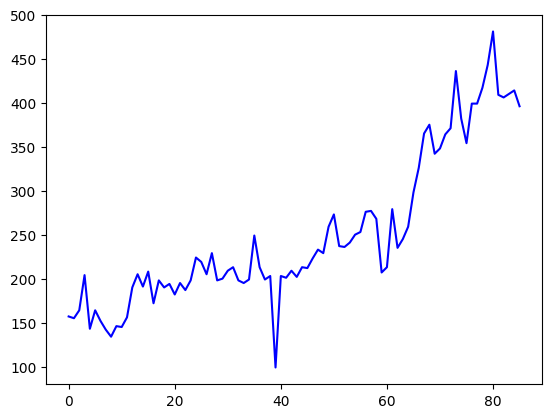

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(week)):
    plt.plot(week[i],'blue')
    plt.show()

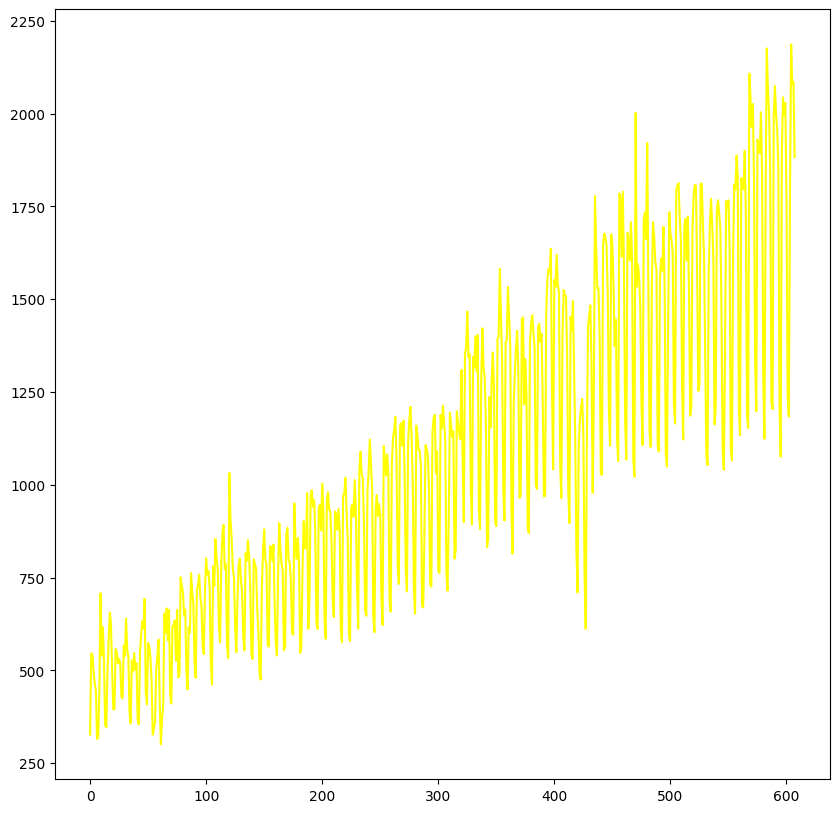

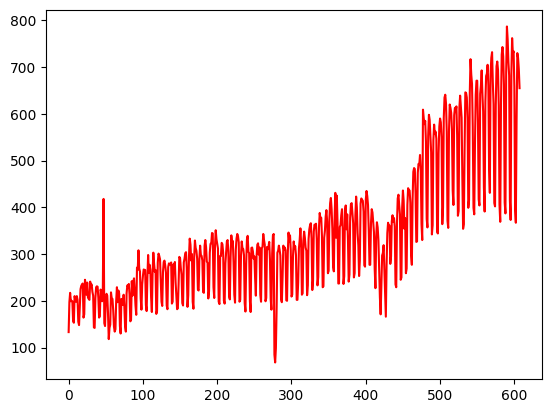

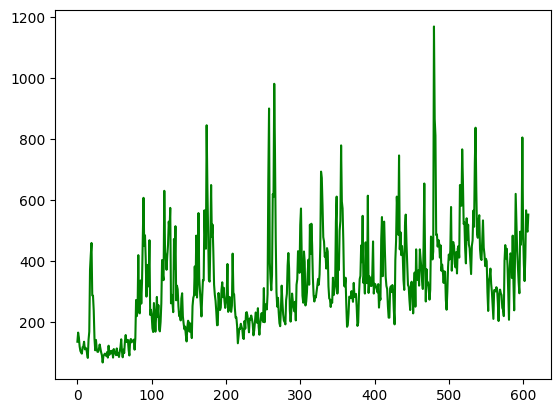

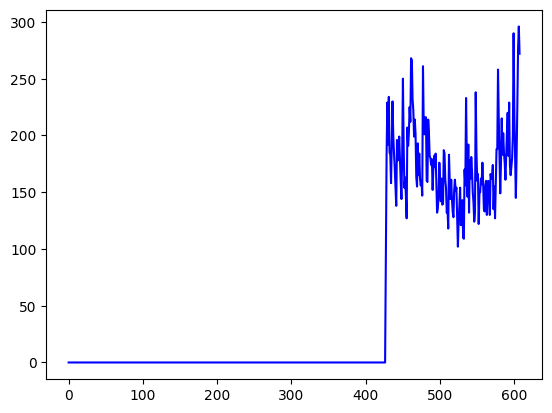

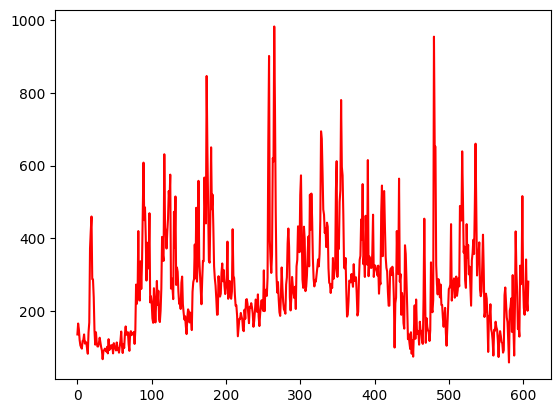

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(jun[0],'yellow')
plt.show()
plt.plot(jun[1],'red')
plt.show()
plt.plot(jun[2],'green')
plt.show()
plt.plot(jun[3],'blue')
plt.show()
plt.plot(jun[4],'red')
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=7)
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(criterion='entropy',min_samples_split=100,min_samples_leaf=10,max_depth=12)
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt


In [ ]:
clf.fit(X,y)
pred = clf.predict(X)
val1=(accuracy_score(y,pred)*100)
print("Accuracy Score for Random Forest :",val1*5)

Accuracy Score for Random Forest : 103.52244389027432


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse1(y_true,y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
rmse1(y,pred)

7.880208960860932

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(X,y)
pred2 = DT.predict(X)
val2= (accuracy_score(y,pred2)*100)
print("Accuracy score for Decision tree classifer : ",val2*5)

Accuracy score for Decision tree classifer :  500.0


In [ ]:
from sklearn.svm import SVC
SVM = SVC(kernel='linear')
SVM.fit(X,y)
pred3 = SVM.predict(X)
val3= (accuracy_score(y,pred3)*100)
print("Accuracy score for SVM : ",val3*5)

Accuracy score for SVM :  41.31338320864505


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

XGboost = XGBClassifier(use_label_encoder=False, objective="multi:softmax", eval_metric="merror", n_estimators=20, max_depth=10, random_state=42)
XGboost.fit(X, y)
pred4 = XGboost.predict(X)
val4 = accuracy_score(y, pred4) * 100
print("Accuracy score for XGBoosting: ", val4)


ValueError: ignored

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Bring some raw data
frequencies =[val1,val2]
freq_series = pd.Series.to_xarray(frequencies)

x_labels = ['Rf','DT','SVM','XGBoost']

#plot the figure
plt.figure(figsize=(12,8))
ax= freq_series.plot(kind='bar')
ax.set_title('Evaluation of ML & Dl')
ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy Range')
ax.set_xticklabels(x_labels)

def add_value_labels(ax,spacing=5):
    #for each bar: Place a label
    for rect in ax.patches:
        y_value= rect.get_height()
        x_value= rect.get_x() + rect.get_width()/2
        space=spacing
        va='bottom'
        if y_value<0:
            space*=-1
            va='top'
        label ="{:.1f}".format(y_value)

    #create annotation
        ax.annotate(label,
                    (x_value,y_value),
                   xytext=(0,space),
                   textcoords="offset points",
                   ha='center',
                   va=va)
# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.show()

AttributeError: ignored